# MNIST Dataset: Error Detection

In [1]:
'''Trains a simple convnet on the MNIST dataset.
Gets to 99.25% test accuracy after 12 epochs
(there is still a lot of margin for parameter tuning).
16 seconds per epoch on a GRID K520 GPU.
'''

from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import utils as np_utils
from sklearn.manifold import TSNE
from sklearn.mixture import GaussianMixture
from sklearn import decomposition, svm
from sklearn import metrics

# choose GPUs
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())




#custom libraries
#base_dir = '/Users/cyrilwendl/Documents/EPFL'
base_dir = '/raid/home/cwendl'  # for guanabana
import sys
sys.path.append(base_dir + '/SIE-Master/Zurich') # Path to density Tree package
sys.path.append(base_dir + '/SIE-Master/Code') # Path to density Tree package

from density_forest.density_forest import *
from density_forest.helpers import *
from density_forest.plots import *
from baselines.helpers import *
from helpers.helpers import *
from helpers.plots import *
from parametric_tSNE.utils import *

/opt/conda/envs/python36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14768937235874935627
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10974989517
locality {
  bus_id: 2
}
incarnation: 4478082378829177758
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:82:00.0, compute capability: 6.1"
]


# Data Import 
Import the data, delete all data in the training set of class 7


In [2]:
# adapted from Source: https://github.com/keras-team/keras/tree/master/examples

# the data, shuffled and split between train and test sets
(x_train, y_train_label), (x_test, y_test_label) = mnist.load_data()

In [3]:
batch_size = 128
num_classes = 10
epochs = 20

# input image dimensions
img_rows, img_cols = 28, 28

# Reshape for Tensorflow
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = np_utils.np_utils.to_categorical(y_train_label, num_classes)
y_test = np_utils.np_utils.to_categorical(y_test_label, num_classes)

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [4]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

print(model.summary())

model_train = False
if model_train:
    model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
    model.save('mnist_models/mnist-weights.h5')
else :
    model = load_model('mnist_models/mnist-weights.h5')

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
__________

#### Make some predictions

In [149]:
y_pred_tr = model.predict(x_train)
y_pred_label_tr = get_y_pred_labels(y_pred_tr, background=False)

y_pred_te = model.predict(x_test)
y_pred_label_te = get_y_pred_labels(y_pred_te, background=False)

In [6]:
c = get_acc_net_max_margin(y_pred_te)
    
pred_acc_mean = np.mean(c)
pred_acc_std = np.std(c)
    
print("Mean accuracy: %.2f %%" % (pred_acc_mean*100) )
print("Std accuracy: %.2f %%" % (pred_acc_std*100) )

pred_acc_high = .95 # 95 % is considered a very high confidence

pct = np.round(len(c[c>pred_acc_high])/len(c),4)*100
print("%.2f%% of all predictions made with an accuracy higher than %.2f%%" % (pct, pred_acc_high))

Mean accuracy: 99.06 %
Std accuracy: 7.08 %
97.47% of all predictions made with an accuracy higher than 0.95%


# Network
MSR, Margin, Entropy

In [7]:
# metrics
y_true = (y_pred_label_te != y_test_label)*1

# msr
y_scores = 1-get_acc_net_msr(y_pred_te)
# PR
precision_msr, recall_msr, thresholds = metrics.precision_recall_curve(y_true, y_scores)
pr_auc_msr = metrics.average_precision_score(y_true, y_scores)
# ROC
roc_auc_msr = metrics.roc_auc_score(y_true, y_scores)
fpr_msr, tpr_msr, _ = metrics.roc_curve(y_true, y_scores)

# margin
y_scores = 1-get_acc_net_max_margin(y_pred_te)
# PR
precision_margin, recall_margin, thresholds = metrics.precision_recall_curve(y_true, y_scores)
pr_auc_margin = metrics.average_precision_score(y_true, y_scores)
# ROC
roc_auc_margin = metrics.roc_auc_score(y_true, y_scores)
fpr_margin, tpr_margin, _ = metrics.roc_curve(y_true, y_scores)

# entropy
y_scores = 1-get_acc_net_entropy(y_pred_te)
# PR
precision_entropy, recall_entropy, thresholds = metrics.precision_recall_curve(y_true, y_scores)
pr_auc_entropy = metrics.average_precision_score(y_true, y_scores)
# ROC
roc_auc_entropy = metrics.roc_auc_score(y_true, y_scores)
fpr_entropy, tpr_entropy, _ = metrics.roc_curve(y_true, y_scores)

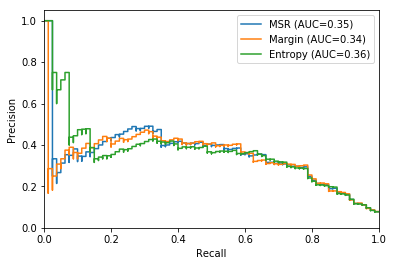

In [8]:
# plot
plt.step(recall_msr, precision_msr, where='post')
plt.step(recall_margin,precision_margin, where='post')
plt.step(recall_entropy, precision_entropy, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.legend([str.format('MSR (AUC=%.2f)' % pr_auc_msr),
            str.format('Margin (AUC=%.2f)' % pr_auc_margin),
            str.format('Entropy (AUC=%.2f)' % pr_auc_entropy)])

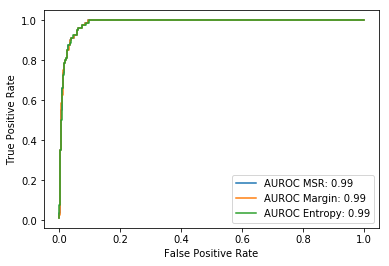

In [9]:
# ROC
plt.plot(fpr_msr,tpr_msr)
plt.plot(fpr_margin,tpr_margin)
plt.plot(fpr_entropy,tpr_entropy)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend([str.format('AUROC MSR: %.2f') % roc_auc_msr,
            str.format('AUROC Margin: %.2f') % roc_auc_margin,
            str.format('AUROC Entropy: %.2f') % roc_auc_entropy
           ])

# Dropout

In [10]:
y_preds = predict_with_dropouts_batch(model, x_test, 
                                      batch_size=100, n_iter=20)

100%|██████████| 100/100 [00:18<00:00,  5.29it/s]


In [11]:
y_pred = np.mean(y_preds, axis=0)
probas = np.mean(np.std(y_preds, -1),0)

0.2963684066733598


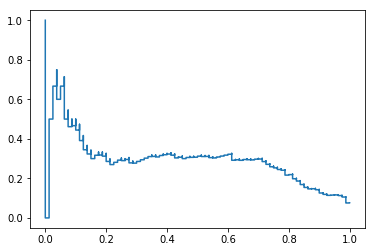

In [12]:
# precision-recall curve
y_scores = -probas
precision_dropout, recall_dropout, thresholds = metrics.precision_recall_curve(y_true, y_scores)
pr_auc_dropout = metrics.average_precision_score(y_true, y_scores)
fpr_dropout, tpr_dropout, _ = metrics.roc_curve(y_true, y_scores)
roc_auc_dropout = metrics.roc_auc_score(y_true, y_scores)

plt.step(recall_dropout,precision_dropout)
print(metrics.auc(recall_dropout, precision_dropout))

## Get Activations, PCA, t-SNE

In [13]:
y_pred_tr = model.predict(x_train)
y_pred_label_tr = get_y_pred_labels(y_pred_tr, background=False)

In [14]:
pred_f_tr = np.where(y_pred_label_tr != y_train_label)[0]
pred_t_tr = np.where(y_pred_label_tr == y_train_label)[0]

pred_f_te = np.where(y_pred_label_te != y_test_label)[0]
pred_t_te = np.where(y_pred_label_te == y_test_label)[0]

In [315]:
# get activations of last layer
n_points = 15000
act_train_all = get_activations(model, 6, x_train[:n_points])[0]
act_train = act_train_all[pred_t_tr[pred_t_tr<n_points]]
print(np.shape(act_train_all))

act_test = get_activations(model, 6, x_test)[0]
print(np.shape(act_test))

(15000, 128)
(10000, 128)


In [316]:
pts_per_class = 300
n_classes=10
dataset_subset_indices = get_balanced_subset_indices(y_test_label, np.arange(n_classes), pts_per_class)

In [317]:
tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=300)
# t-SNE visualization after PCA
#tsne_all = tsne.fit_transform(act_test[np.concatenate(dataset_subset_indices)])

In [318]:
# color scale and legend for t-sne plots
colors = plt.cm.rainbow(np.linspace(0,1,n_classes))[:,:3]
names = ['Class '+str(i) for i in range(10)]
classes_to_keep = np.unique(y_test_label)

# plot
tsne_y = y_test_label[np.concatenate(dataset_subset_indices)]

Variance explained by first 15 components: 0.84


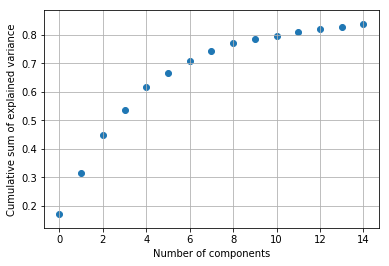

In [319]:
# PCA
n_components = 15
pca = decomposition.PCA(n_components=15)
pca.fit(act_train)

# plot
print("Variance explained by first %i components: %.2f" % (n_components, np.sum(pca.explained_variance_ratio_[:n_components])))
plt.scatter(np.arange(n_components), np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Number of components")
plt.ylabel("Cumulative sum of explained variance")
plt.grid()
plt.savefig("../Figures/DF/pca_components.pdf", bbox_inches='tight', pad_inches=0)
plt.show()

In [326]:
X_train = pca.transform(act_train)
X_train_all = pca.transform(act_train_all)
X_test = pca.transform(act_test)

#### Visualize PCA

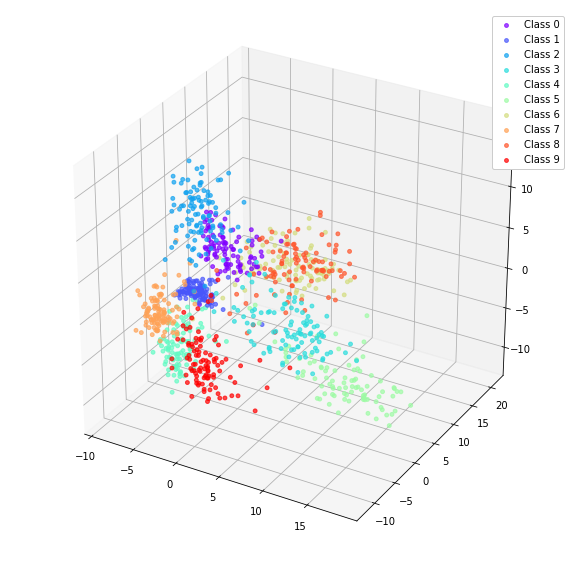

In [327]:
# test sample (with unseen class)
plot_pts_3d(X_test, y_test_label, classes_to_keep, names, colors, subsample_pct=.1)

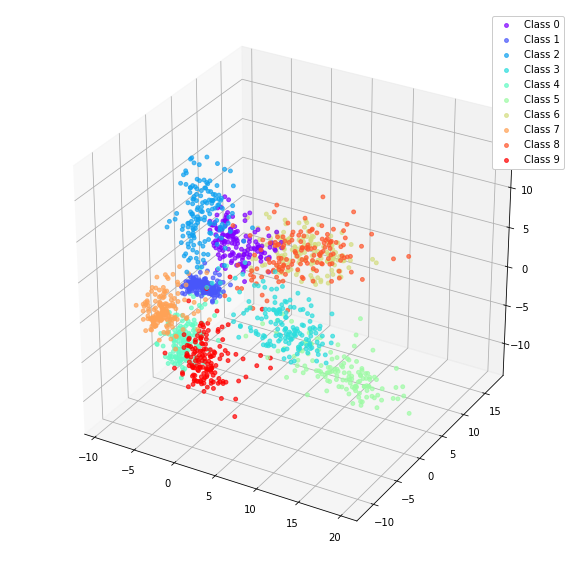

In [330]:
# training sample (without unseen class)
y_pca = y_train_label[pred_t_tr][:len(X_train)]
plot_pts_3d(X_train, y_pca, classes_to_keep, names, colors, subsample_pct=.1)

In [331]:
# t-SNE visualization after PCA
%time tsne_all = tsne.fit_transform(X_test)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.016s...
[t-SNE] Computed neighbors for 10000 samples in 0.915s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 1.451230
[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.538773
[t-SNE] Error after 300 iterations: 2.662843
CPU times: user 1min 1s, sys: 37.2

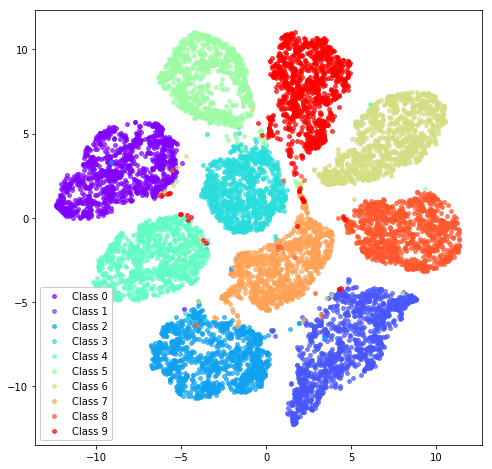

In [332]:
# plot
fig, ax = plt.subplots(1,1,figsize=(8,8))
plot_pts_2d(tsne_all, y_test_label, ax, classes_to_keep, names,
           colors, subsample_pct=1)

### GMM
GMM, calculate 

In [333]:
def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

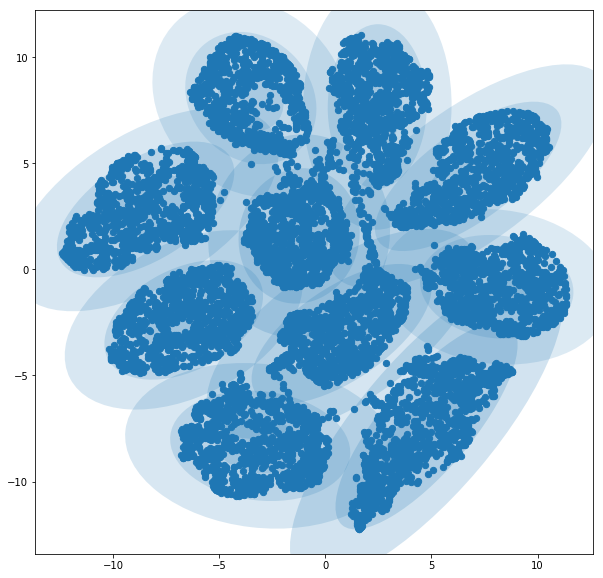

In [334]:
gmm = GaussianMixture(n_components=len(classes_to_keep), max_iter=10000)
fig, axes = plt.subplots(1,1,figsize=(10,10))
plot_gmm(gmm, tsne_all, label=False, ax=axes)

In [370]:
def scorer_roc_probas(clf, X, y=None):
    """
    custom scorer for cross validation returning AUROC
    clf = classifier
    X = validation data
    y = optional gt data
    """
    probas = gmm.predict_proba(X)
    
    probas = -get_acc_net_entropy(probas)
    AUROC = metrics.roc_auc_score(y, probas)
    return AUROC

In [371]:
from sklearn.model_selection import PredefinedSplit
X = np.array([[1, 2], [4, 5], [6, 7], [8, 9]])
y = np.array([0, 0, 1, 1])
test_fold = [-1, -1, 0, 0]
ps = PredefinedSplit(test_fold)
ps.get_n_splits()

print(ps)       

for train_index, test_index in ps.split():
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    print(X_train)
    print(X_test)
    
for train_index, test_index in ps.split():
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    print(X_train)
    print(X_test)

PredefinedSplit(test_fold=array([-1, -1,  0,  0]))
TRAIN: [0 1] TEST: [2 3]
[[1 2]
 [4 5]]
[[6 7]
 [8 9]]
TRAIN: [0 1] TEST: [2 3]
[[1 2]
 [4 5]]
[[6 7]
 [8 9]]


In [372]:
y_pred_label_tr

array([5, 0, 4, ..., 5, 6, 8])

In [373]:
# TODO custom CV generator (X_train with only 0, X_val with 0 and 1)
y_true_tr = ((y_pred_label_tr != y_train_label)[:n_points])*1

array([0, 0, 0, ..., 0, 1, 0])

In [394]:
test_fold = y_true_tr[:]
test_fold[y_true_tr == 1] = -1 
test_fold[y_true_tr == 0] = np.random.randint(2, size=sum(y_true_tr==0))

In [395]:
np.unique(test_fold)

array([-1,  0,  1])

In [396]:
from sklearn.model_selection import PredefinedSplit
ps = PredefinedSplit(test_fold)
ps.get_n_splits()


for train_index, test_index in ps.split():
    print("TRAIN:", train_index, "TEST:", test_index)

TRAIN: [    0     1     2 ... 14994 14995 14996] TEST: [    5     6     9 ... 14997 14998 14999]
TRAIN: [    5     6     9 ... 14997 14998 14999] TEST: [    0     1     2 ... 14994 14995 14996]


In [397]:
len(test_fold[train_index])

7462

In [398]:
np.shape(X_train_all)

(15000, 15)

In [399]:
np.shape(test_fold)

(15000,)

In [400]:
# TODO cross-validation
from sklearn.model_selection import GridSearchCV

# Set the parameters by cross-validation
tuned_parameters = [{'n_components': np.arange(1,10)}]

clf = GridSearchCV(GaussianMixture(), tuned_parameters, scoring=scorer_roc_probas, 
                   cv=PredefinedSplit(test_fold), n_jobs=-1, verbose=1)
clf.fit(X_train_all, y_true_tr)    

Fitting 2 folds for each of 9 candidates, totalling 18 fits


JoblibValueError: JoblibValueError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
/opt/conda/envs/python36/lib/python3.6/runpy.py in _run_module_as_main(mod_name='ipykernel_launcher', alter_argv=1)
    188         sys.exit(msg)
    189     main_globals = sys.modules["__main__"].__dict__
    190     if alter_argv:
    191         sys.argv[0] = mod_spec.origin
    192     return _run_code(code, main_globals, None,
--> 193                      "__main__", mod_spec)
        mod_spec = ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py')
    194 
    195 def run_module(mod_name, init_globals=None,
    196                run_name=None, alter_sys=False):
    197     """Execute a module's code without importing it

...........................................................................
/opt/conda/envs/python36/lib/python3.6/runpy.py in _run_code(code=<code object <module> at 0x7fec703c4660, file "/...3.6/site-packages/ipykernel_launcher.py", line 5>, run_globals={'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': '/opt/conda/envs/python36/lib/python3.6/site-packages/__pycache__/ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/opt/conda/envs/python36/lib/python3.6/site-packages/ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from '/opt/conda/e.../python3.6/site-packages/ipykernel/kernelapp.py'>, ...}, init_globals=None, mod_name='__main__', mod_spec=ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), pkg_name='', script_name=None)
     80                        __cached__ = cached,
     81                        __doc__ = None,
     82                        __loader__ = loader,
     83                        __package__ = pkg_name,
     84                        __spec__ = mod_spec)
---> 85     exec(code, run_globals)
        code = <code object <module> at 0x7fec703c4660, file "/...3.6/site-packages/ipykernel_launcher.py", line 5>
        run_globals = {'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': '/opt/conda/envs/python36/lib/python3.6/site-packages/__pycache__/ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/opt/conda/envs/python36/lib/python3.6/site-packages/ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from '/opt/conda/e.../python3.6/site-packages/ipykernel/kernelapp.py'>, ...}
     86     return run_globals
     87 
     88 def _run_module_code(code, init_globals=None,
     89                     mod_name=None, mod_spec=None,

...........................................................................
/opt/conda/envs/python36/lib/python3.6/site-packages/ipykernel_launcher.py in <module>()
     11     # This is added back by InteractiveShellApp.init_path()
     12     if sys.path[0] == '':
     13         del sys.path[0]
     14 
     15     from ipykernel import kernelapp as app
---> 16     app.launch_new_instance()

...........................................................................
/opt/conda/envs/python36/lib/python3.6/site-packages/traitlets/config/application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    653 
    654         If a global instance already exists, this reinitializes and starts it
    655         """
    656         app = cls.instance(**kwargs)
    657         app.initialize(argv)
--> 658         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    659 
    660 #-----------------------------------------------------------------------------
    661 # utility functions, for convenience
    662 #-----------------------------------------------------------------------------

...........................................................................
/opt/conda/envs/python36/lib/python3.6/site-packages/ipykernel/kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    481         if self.poller is not None:
    482             self.poller.start()
    483         self.kernel.start()
    484         self.io_loop = ioloop.IOLoop.current()
    485         try:
--> 486             self.io_loop.start()
        self.io_loop.start = <bound method BaseAsyncIOLoop.start of <tornado.platform.asyncio.AsyncIOMainLoop object>>
    487         except KeyboardInterrupt:
    488             pass
    489 
    490 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
/opt/conda/envs/python36/lib/python3.6/site-packages/tornado/platform/asyncio.py in start(self=<tornado.platform.asyncio.AsyncIOMainLoop object>)
    107         except RuntimeError:
    108             old_loop = None
    109         try:
    110             self._setup_logging()
    111             asyncio.set_event_loop(self.asyncio_loop)
--> 112             self.asyncio_loop.run_forever()
        self.asyncio_loop.run_forever = <bound method BaseEventLoop.run_forever of <_Uni...EventLoop running=True closed=False debug=False>>
    113         finally:
    114             asyncio.set_event_loop(old_loop)
    115 
    116     def stop(self):

...........................................................................
/opt/conda/envs/python36/lib/python3.6/asyncio/base_events.py in run_forever(self=<_UnixSelectorEventLoop running=True closed=False debug=False>)
    416             sys.set_asyncgen_hooks(firstiter=self._asyncgen_firstiter_hook,
    417                                    finalizer=self._asyncgen_finalizer_hook)
    418         try:
    419             events._set_running_loop(self)
    420             while True:
--> 421                 self._run_once()
        self._run_once = <bound method BaseEventLoop._run_once of <_UnixS...EventLoop running=True closed=False debug=False>>
    422                 if self._stopping:
    423                     break
    424         finally:
    425             self._stopping = False

...........................................................................
/opt/conda/envs/python36/lib/python3.6/asyncio/base_events.py in _run_once(self=<_UnixSelectorEventLoop running=True closed=False debug=False>)
   1426                         logger.warning('Executing %s took %.3f seconds',
   1427                                        _format_handle(handle), dt)
   1428                 finally:
   1429                     self._current_handle = None
   1430             else:
-> 1431                 handle._run()
        handle._run = <bound method Handle._run of <Handle BaseAsyncIOLoop._handle_events(12, 1)>>
   1432         handle = None  # Needed to break cycles when an exception occurs.
   1433 
   1434     def _set_coroutine_wrapper(self, enabled):
   1435         try:

...........................................................................
/opt/conda/envs/python36/lib/python3.6/asyncio/events.py in _run(self=<Handle BaseAsyncIOLoop._handle_events(12, 1)>)
    140             self._callback = None
    141             self._args = None
    142 
    143     def _run(self):
    144         try:
--> 145             self._callback(*self._args)
        self._callback = <bound method BaseAsyncIOLoop._handle_events of <tornado.platform.asyncio.AsyncIOMainLoop object>>
        self._args = (12, 1)
    146         except Exception as exc:
    147             cb = _format_callback_source(self._callback, self._args)
    148             msg = 'Exception in callback {}'.format(cb)
    149             context = {

...........................................................................
/opt/conda/envs/python36/lib/python3.6/site-packages/tornado/platform/asyncio.py in _handle_events(self=<tornado.platform.asyncio.AsyncIOMainLoop object>, fd=12, events=1)
     97             self.writers.remove(fd)
     98         del self.handlers[fd]
     99 
    100     def _handle_events(self, fd, events):
    101         fileobj, handler_func = self.handlers[fd]
--> 102         handler_func(fileobj, events)
        handler_func = <function wrap.<locals>.null_wrapper>
        fileobj = <zmq.sugar.socket.Socket object>
        events = 1
    103 
    104     def start(self):
    105         try:
    106             old_loop = asyncio.get_event_loop()

...........................................................................
/opt/conda/envs/python36/lib/python3.6/site-packages/tornado/stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 1), **kwargs={})
    271         # Fast path when there are no active contexts.
    272         def null_wrapper(*args, **kwargs):
    273             try:
    274                 current_state = _state.contexts
    275                 _state.contexts = cap_contexts[0]
--> 276                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 1)
        kwargs = {}
    277             finally:
    278                 _state.contexts = current_state
    279         null_wrapper._wrapped = True
    280         return null_wrapper

...........................................................................
/opt/conda/envs/python36/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=1)
    445             return
    446         zmq_events = self.socket.EVENTS
    447         try:
    448             # dispatch events:
    449             if zmq_events & zmq.POLLIN and self.receiving():
--> 450                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    451                 if not self.socket:
    452                     return
    453             if zmq_events & zmq.POLLOUT and self.sending():
    454                 self._handle_send()

...........................................................................
/opt/conda/envs/python36/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    475             else:
    476                 raise
    477         else:
    478             if self._recv_callback:
    479                 callback = self._recv_callback
--> 480                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function wrap.<locals>.null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    481         
    482 
    483     def _handle_send(self):
    484         """Handle a send event."""

...........................................................................
/opt/conda/envs/python36/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function wrap.<locals>.null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    427         close our socket."""
    428         try:
    429             # Use a NullContext to ensure that all StackContexts are run
    430             # inside our blanket exception handler rather than outside.
    431             with stack_context.NullContext():
--> 432                 callback(*args, **kwargs)
        callback = <function wrap.<locals>.null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    433         except:
    434             gen_log.error("Uncaught exception in ZMQStream callback",
    435                           exc_info=True)
    436             # Re-raise the exception so that IOLoop.handle_callback_exception

...........................................................................
/opt/conda/envs/python36/lib/python3.6/site-packages/tornado/stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    271         # Fast path when there are no active contexts.
    272         def null_wrapper(*args, **kwargs):
    273             try:
    274                 current_state = _state.contexts
    275                 _state.contexts = cap_contexts[0]
--> 276                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    277             finally:
    278                 _state.contexts = current_state
    279         null_wrapper._wrapped = True
    280         return null_wrapper

...........................................................................
/opt/conda/envs/python36/lib/python3.6/site-packages/ipykernel/kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    278         if self.control_stream:
    279             self.control_stream.on_recv(self.dispatch_control, copy=False)
    280 
    281         def make_dispatcher(stream):
    282             def dispatcher(msg):
--> 283                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    284             return dispatcher
    285 
    286         for s in self.shell_streams:
    287             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
/opt/conda/envs/python36/lib/python3.6/site-packages/ipykernel/kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': '# TODO cross-validation\nfrom sklearn.model_selec...1, verbose=1)\nclf.fit(X_train_all, y_true_tr)    ', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 6, 14, 16, 53, 52, 946490, tzinfo=tzutc()), 'msg_id': 'c699170bed26415084ef3ba2b9b82318', 'msg_type': 'execute_request', 'session': '5e8166e1e3d54d7b9e6a3355f1a978d0', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': 'c699170bed26415084ef3ba2b9b82318', 'msg_type': 'execute_request', 'parent_header': {}})
    228             self.log.warn("Unknown message type: %r", msg_type)
    229         else:
    230             self.log.debug("%s: %s", msg_type, msg)
    231             self.pre_handler_hook()
    232             try:
--> 233                 handler(stream, idents, msg)
        handler = <bound method Kernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = [b'5e8166e1e3d54d7b9e6a3355f1a978d0']
        msg = {'buffers': [], 'content': {'allow_stdin': True, 'code': '# TODO cross-validation\nfrom sklearn.model_selec...1, verbose=1)\nclf.fit(X_train_all, y_true_tr)    ', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 6, 14, 16, 53, 52, 946490, tzinfo=tzutc()), 'msg_id': 'c699170bed26415084ef3ba2b9b82318', 'msg_type': 'execute_request', 'session': '5e8166e1e3d54d7b9e6a3355f1a978d0', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': 'c699170bed26415084ef3ba2b9b82318', 'msg_type': 'execute_request', 'parent_header': {}}
    234             except Exception:
    235                 self.log.error("Exception in message handler:", exc_info=True)
    236             finally:
    237                 self.post_handler_hook()

...........................................................................
/opt/conda/envs/python36/lib/python3.6/site-packages/ipykernel/kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=[b'5e8166e1e3d54d7b9e6a3355f1a978d0'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': '# TODO cross-validation\nfrom sklearn.model_selec...1, verbose=1)\nclf.fit(X_train_all, y_true_tr)    ', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 6, 14, 16, 53, 52, 946490, tzinfo=tzutc()), 'msg_id': 'c699170bed26415084ef3ba2b9b82318', 'msg_type': 'execute_request', 'session': '5e8166e1e3d54d7b9e6a3355f1a978d0', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': 'c699170bed26415084ef3ba2b9b82318', 'msg_type': 'execute_request', 'parent_header': {}})
    394         if not silent:
    395             self.execution_count += 1
    396             self._publish_execute_input(code, parent, self.execution_count)
    397 
    398         reply_content = self.do_execute(code, silent, store_history,
--> 399                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    400 
    401         # Flush output before sending the reply.
    402         sys.stdout.flush()
    403         sys.stderr.flush()

...........................................................................
/opt/conda/envs/python36/lib/python3.6/site-packages/ipykernel/ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code='# TODO cross-validation\nfrom sklearn.model_selec...1, verbose=1)\nclf.fit(X_train_all, y_true_tr)    ', silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    203 
    204         self._forward_input(allow_stdin)
    205 
    206         reply_content = {}
    207         try:
--> 208             res = shell.run_cell(code, store_history=store_history, silent=silent)
        res = undefined
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = '# TODO cross-validation\nfrom sklearn.model_selec...1, verbose=1)\nclf.fit(X_train_all, y_true_tr)    '
        store_history = True
        silent = False
    209         finally:
    210             self._restore_input()
    211 
    212         if res.error_before_exec is not None:

...........................................................................
/opt/conda/envs/python36/lib/python3.6/site-packages/ipykernel/zmqshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, *args=('# TODO cross-validation\nfrom sklearn.model_selec...1, verbose=1)\nclf.fit(X_train_all, y_true_tr)    ',), **kwargs={'silent': False, 'store_history': True})
    532             )
    533         self.payload_manager.write_payload(payload)
    534 
    535     def run_cell(self, *args, **kwargs):
    536         self._last_traceback = None
--> 537         return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
        self.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        args = ('# TODO cross-validation\nfrom sklearn.model_selec...1, verbose=1)\nclf.fit(X_train_all, y_true_tr)    ',)
        kwargs = {'silent': False, 'store_history': True}
    538 
    539     def _showtraceback(self, etype, evalue, stb):
    540         # try to preserve ordering of tracebacks and print statements
    541         sys.stdout.flush()

...........................................................................
/opt/conda/envs/python36/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell='# TODO cross-validation\nfrom sklearn.model_selec...1, verbose=1)\nclf.fit(X_train_all, y_true_tr)    ', store_history=True, silent=False, shell_futures=True)
   2723                 self.displayhook.exec_result = result
   2724 
   2725                 # Execute the user code
   2726                 interactivity = "none" if silent else self.ast_node_interactivity
   2727                 has_raised = self.run_ast_nodes(code_ast.body, cell_name,
-> 2728                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler object>
   2729                 
   2730                 self.last_execution_succeeded = not has_raised
   2731                 self.last_execution_result = result
   2732 

...........................................................................
/opt/conda/envs/python36/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.ImportFrom object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Expr object>], cell_name='<ipython-input-400-38debaae46a7>', interactivity='last', compiler=<IPython.core.compilerop.CachingCompiler object>, result=<ExecutionResult object at 7fec489ed278, executi..._before_exec=None error_in_exec=None result=None>)
   2851                     return True
   2852 
   2853             for i, node in enumerate(to_run_interactive):
   2854                 mod = ast.Interactive([node])
   2855                 code = compiler(mod, cell_name, "single")
-> 2856                 if self.run_code(code, result):
        self.run_code = <bound method InteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x7fec48973780, file "<ipython-input-400-38debaae46a7>", line 9>
        result = <ExecutionResult object at 7fec489ed278, executi..._before_exec=None error_in_exec=None result=None>
   2857                     return True
   2858 
   2859             # Flush softspace
   2860             if softspace(sys.stdout, 0):

...........................................................................
/opt/conda/envs/python36/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x7fec48973780, file "<ipython-input-400-38debaae46a7>", line 9>, result=<ExecutionResult object at 7fec489ed278, executi..._before_exec=None error_in_exec=None result=None>)
   2905         outflag = True  # happens in more places, so it's easier as default
   2906         try:
   2907             try:
   2908                 self.hooks.pre_run_code_hook()
   2909                 #rprint('Running code', repr(code_obj)) # dbg
-> 2910                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x7fec48973780, file "<ipython-input-400-38debaae46a7>", line 9>
        self.user_global_ns = {'Axes3D': <class 'mpl_toolkits.mplot3d.axes3d.Axes3D'>, 'Conv2D': <class 'keras.layers.convolutional.Conv2D'>, 'Dense': <class 'keras.layers.core.Dense'>, 'DensityNode': <class 'density_forest.density_tree.DensityNode'>, 'Dropout': <class 'keras.layers.core.Dropout'>, 'Ellipse': <class 'matplotlib.patches.Ellipse'>, 'Flatten': <class 'keras.layers.core.Flatten'>, 'GaussianMixture': <class 'sklearn.mixture.gaussian_mixture.GaussianMixture'>, 'GridSearchCV': <class 'sklearn.model_selection._search.GridSearchCV'>, 'Hbeta_scalar': <function Hbeta_scalar>, ...}
        self.user_ns = {'Axes3D': <class 'mpl_toolkits.mplot3d.axes3d.Axes3D'>, 'Conv2D': <class 'keras.layers.convolutional.Conv2D'>, 'Dense': <class 'keras.layers.core.Dense'>, 'DensityNode': <class 'density_forest.density_tree.DensityNode'>, 'Dropout': <class 'keras.layers.core.Dropout'>, 'Ellipse': <class 'matplotlib.patches.Ellipse'>, 'Flatten': <class 'keras.layers.core.Flatten'>, 'GaussianMixture': <class 'sklearn.mixture.gaussian_mixture.GaussianMixture'>, 'GridSearchCV': <class 'sklearn.model_selection._search.GridSearchCV'>, 'Hbeta_scalar': <function Hbeta_scalar>, ...}
   2911             finally:
   2912                 # Reset our crash handler in place
   2913                 sys.excepthook = old_excepthook
   2914         except SystemExit as e:

...........................................................................
/raid/home/cwendl/SIE-Master/Code/<ipython-input-400-38debaae46a7> in <module>()
      4 # Set the parameters by cross-validation
      5 tuned_parameters = [{'n_components': np.arange(1,10)}]
      6 
      7 clf = GridSearchCV(GaussianMixture(), tuned_parameters, scoring=scorer_roc_probas, 
      8                    cv=PredefinedSplit(test_fold), n_jobs=-1, verbose=1)
----> 9 clf.fit(X_train_all, y_true_tr)    

...........................................................................
/opt/conda/envs/python36/lib/python3.6/site-packages/sklearn/model_selection/_search.py in fit(self=GridSearchCV(cv=PredefinedSplit(test_fold=array(... scorer_roc_probas at 0x7fec48881620>, verbose=1), X=array([[ 1.2764094e+01, -5.2281344e-01, -4.95799...  5.3281444e-01, -8.0828995e-01]], dtype=float32), y=array([1, 1, 1, ..., 0, 0, 0]), groups=None, **fit_params={})
    634                                   return_train_score=self.return_train_score,
    635                                   return_n_test_samples=True,
    636                                   return_times=True, return_parameters=False,
    637                                   error_score=self.error_score)
    638           for parameters, (train, test) in product(candidate_params,
--> 639                                                    cv.split(X, y, groups)))
        cv.split = <bound method PredefinedSplit.split of PredefinedSplit(test_fold=array([1, 1, ..., 0, 0]))>
        X = array([[ 1.2764094e+01, -5.2281344e-01, -4.95799...  5.3281444e-01, -8.0828995e-01]], dtype=float32)
        y = array([1, 1, 1, ..., 0, 0, 0])
        groups = None
    640 
    641         # if one choose to see train score, "out" will contain train score info
    642         if self.return_train_score:
    643             (train_score_dicts, test_score_dicts, test_sample_counts, fit_time,

...........................................................................
/opt/conda/envs/python36/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=Parallel(n_jobs=-1), iterable=<generator object BaseSearchCV.fit.<locals>.<genexpr>>)
    784             if pre_dispatch == "all" or n_jobs == 1:
    785                 # The iterable was consumed all at once by the above for loop.
    786                 # No need to wait for async callbacks to trigger to
    787                 # consumption.
    788                 self._iterating = False
--> 789             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=-1)>
    790             # Make sure that we get a last message telling us we are done
    791             elapsed_time = time.time() - self._start_time
    792             self._print('Done %3i out of %3i | elapsed: %s finished',
    793                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
ValueError                                         Thu Jun 14 18:53:54 2018
PID: 29484                Python 3.6.4: /opt/conda/envs/python36/bin/python
...........................................................................
/opt/conda/envs/python36/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<function _fit_and_score>, (GaussianMixture(covariance_type='full', init_par...interval=10, warm_start=False, weights_init=None), array([[ 1.2764094e+01, -5.2281344e-01, -4.95799...  5.3281444e-01, -8.0828995e-01]], dtype=float32), array([1, 1, 1, ..., 0, 0, 0]), {'score': <function scorer_roc_probas>}, array([    0,     1,     2, ..., 14994, 14995, 14996]), array([    5,     6,     9, ..., 14997, 14998, 14999]), 1, {'n_components': 1}), {'error_score': 'raise', 'fit_params': {}, 'return_n_test_samples': True, 'return_parameters': False, 'return_times': True, 'return_train_score': 'warn'})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/opt/conda/envs/python36/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in <listcomp>(.0=<list_iterator object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _fit_and_score>
        args = (GaussianMixture(covariance_type='full', init_par...interval=10, warm_start=False, weights_init=None), array([[ 1.2764094e+01, -5.2281344e-01, -4.95799...  5.3281444e-01, -8.0828995e-01]], dtype=float32), array([1, 1, 1, ..., 0, 0, 0]), {'score': <function scorer_roc_probas>}, array([    0,     1,     2, ..., 14994, 14995, 14996]), array([    5,     6,     9, ..., 14997, 14998, 14999]), 1, {'n_components': 1})
        kwargs = {'error_score': 'raise', 'fit_params': {}, 'return_n_test_samples': True, 'return_parameters': False, 'return_times': True, 'return_train_score': 'warn'}
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/opt/conda/envs/python36/lib/python3.6/site-packages/sklearn/model_selection/_validation.py in _fit_and_score(estimator=GaussianMixture(covariance_type='full', init_par...interval=10, warm_start=False, weights_init=None), X=array([[ 1.2764094e+01, -5.2281344e-01, -4.95799...  5.3281444e-01, -8.0828995e-01]], dtype=float32), y=array([1, 1, 1, ..., 0, 0, 0]), scorer={'score': <function scorer_roc_probas>}, train=array([    0,     1,     2, ..., 14994, 14995, 14996]), test=array([    5,     6,     9, ..., 14997, 14998, 14999]), verbose=1, parameters={'n_components': 1}, fit_params={}, return_train_score='warn', return_parameters=False, return_n_test_samples=True, return_times=True, error_score='raise')
    483                              " make sure that it has been spelled correctly.)")
    484 
    485     else:
    486         fit_time = time.time() - start_time
    487         # _score will return dict if is_multimetric is True
--> 488         test_scores = _score(estimator, X_test, y_test, scorer, is_multimetric)
        test_scores = {}
        estimator = GaussianMixture(covariance_type='full', init_par...interval=10, warm_start=False, weights_init=None)
        X_test = array([[-3.0700524e+00, -5.1696724e-01,  1.11923...  5.3281444e-01, -8.0828995e-01]], dtype=float32)
        y_test = array([0, 0, 0, ..., 0, 0, 0])
        scorer = {'score': <function scorer_roc_probas>}
        is_multimetric = True
    489         score_time = time.time() - start_time - fit_time
    490         if return_train_score:
    491             train_scores = _score(estimator, X_train, y_train, scorer,
    492                                   is_multimetric)

...........................................................................
/opt/conda/envs/python36/lib/python3.6/site-packages/sklearn/model_selection/_validation.py in _score(estimator=GaussianMixture(covariance_type='full', init_par...interval=10, warm_start=False, weights_init=None), X_test=array([[-3.0700524e+00, -5.1696724e-01,  1.11923...  5.3281444e-01, -8.0828995e-01]], dtype=float32), y_test=array([0, 0, 0, ..., 0, 0, 0]), scorer={'score': <function scorer_roc_probas>}, is_multimetric=True)
    518 
    519     Will return a single float if is_multimetric is False and a dict of floats,
    520     if is_multimetric is True
    521     """
    522     if is_multimetric:
--> 523         return _multimetric_score(estimator, X_test, y_test, scorer)
        estimator = GaussianMixture(covariance_type='full', init_par...interval=10, warm_start=False, weights_init=None)
        X_test = array([[-3.0700524e+00, -5.1696724e-01,  1.11923...  5.3281444e-01, -8.0828995e-01]], dtype=float32)
        y_test = array([0, 0, 0, ..., 0, 0, 0])
        scorer = {'score': <function scorer_roc_probas>}
    524     else:
    525         if y_test is None:
    526             score = scorer(estimator, X_test)
    527         else:

...........................................................................
/opt/conda/envs/python36/lib/python3.6/site-packages/sklearn/model_selection/_validation.py in _multimetric_score(estimator=GaussianMixture(covariance_type='full', init_par...interval=10, warm_start=False, weights_init=None), X_test=array([[-3.0700524e+00, -5.1696724e-01,  1.11923...  5.3281444e-01, -8.0828995e-01]], dtype=float32), y_test=array([0, 0, 0, ..., 0, 0, 0]), scorers={'score': <function scorer_roc_probas>})
    548 
    549     for name, scorer in scorers.items():
    550         if y_test is None:
    551             score = scorer(estimator, X_test)
    552         else:
--> 553             score = scorer(estimator, X_test, y_test)
        score = undefined
        scorer = <function scorer_roc_probas>
        estimator = GaussianMixture(covariance_type='full', init_par...interval=10, warm_start=False, weights_init=None)
        X_test = array([[-3.0700524e+00, -5.1696724e-01,  1.11923...  5.3281444e-01, -8.0828995e-01]], dtype=float32)
        y_test = array([0, 0, 0, ..., 0, 0, 0])
    554 
    555         if hasattr(score, 'item'):
    556             try:
    557                 # e.g. unwrap memmapped scalars

...........................................................................
/raid/home/cwendl/SIE-Master/Code/<ipython-input-370-16ded62e0186> in scorer_roc_probas(clf=GaussianMixture(covariance_type='full', init_par...interval=10, warm_start=False, weights_init=None), X=array([[-3.0700524e+00, -5.1696724e-01,  1.11923...  5.3281444e-01, -8.0828995e-01]], dtype=float32), y=array([0, 0, 0, ..., 0, 0, 0]))
      3     custom scorer for cross validation returning AUROC
      4     clf = classifier
      5     X = validation data
      6     y = optional gt data
      7     """
----> 8     probas = gmm.predict_proba(X)
      9     
     10     probas = -get_acc_net_entropy(probas)
     11     AUROC = metrics.roc_auc_score(y, probas)
     12     return AUROC

...........................................................................
/opt/conda/envs/python36/lib/python3.6/site-packages/sklearn/mixture/base.py in predict_proba(self=GaussianMixture(covariance_type='full', init_par...interval=10, warm_start=False, weights_init=None), X=array([[-3.0700524e+00, -5.1696724e-01,  1.11923...  5.3281444e-01, -8.0828995e-01]], dtype=float32))
    353         resp : array, shape (n_samples, n_components)
    354             Returns the probability each Gaussian (state) in
    355             the model given each sample.
    356         """
    357         self._check_is_fitted()
--> 358         X = _check_X(X, None, self.means_.shape[1])
        X = array([[-3.0700524e+00, -5.1696724e-01,  1.11923...  5.3281444e-01, -8.0828995e-01]], dtype=float32)
        self.means_.shape = (10, 2)
    359         _, log_resp = self._estimate_log_prob_resp(X)
    360         return np.exp(log_resp)
    361 
    362     def sample(self, n_samples=1):

...........................................................................
/opt/conda/envs/python36/lib/python3.6/site-packages/sklearn/mixture/base.py in _check_X(X=array([[-3.0700524e+00, -5.1696724e-01,  1.11923...  5.3281444e-01, -8.0828995e-01]], dtype=float32), n_components=None, n_features=2)
     57                          'but got n_components = %d, n_samples = %d'
     58                          % (n_components, X.shape[0]))
     59     if n_features is not None and X.shape[1] != n_features:
     60         raise ValueError("Expected the input data X have %d features, "
     61                          "but got %d features"
---> 62                          % (n_features, X.shape[1]))
        n_features = 2
        X.shape = (7441, 15)
     63     return X
     64 
     65 
     66 class BaseMixture(six.with_metaclass(ABCMeta, DensityMixin, BaseEstimator)):

ValueError: Expected the input data X have 2 features, but got 15 features
___________________________________________________________________________

In [181]:
clf.cv_results_

/opt/conda/envs/python36/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/opt/conda/envs/python36/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/opt/conda/envs/python36/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/opt/conda/envs/python36/li

{'mean_fit_time': array([0.44556332, 1.29120593, 2.25991139, 1.97584877, 2.50969658,
        3.00092607, 3.2029099 , 3.34263878, 3.3987483 ]),
 'mean_score_time': array([0.04886556, 0.01405063, 0.01831212, 0.01939878, 0.01375165,
        0.00541801, 0.00295348, 0.00307274, 0.00582299]),
 'mean_test_score': array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]),
 'mean_train_score': array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]),
 'param_n_components': masked_array(data=[1, 2, 3, 4, 5, 6, 7, 8, 9],
              mask=[False, False, False, False, False, False, False, False,
                    False],
        fill_value='?',
             dtype=object),
 'params': [{'n_components': 1},
  {'n_components': 2},
  {'n_components': 3},
  {'n_components': 4},
  {'n_components': 5},
  {'n_components': 6},
  {'n_components': 7},
  {'n_components': 8},
  {'n_components': 9}],
 'rank_test_score': array([1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32),
 'split0_test_score': array([0.5, 0.5, 0.5, 0.5, 0

In [71]:
clf.best_params_

{'n_components': 45}

In [183]:
gmm = GaussianMixture(n_components=len(classes_to_keep), max_iter=10000)
#gmm = clf.best_estimator_

gmm.fit(X_train)
probas = gmm.predict_proba(X_test)
# get probability
probas = get_acc_net_entropy(probas)

# Metrics
# PR
precision_gmm, recall_gmm, thresholds = metrics.precision_recall_curve(y_true, -probas)
pr_auc_gmm = metrics.auc(recall_gmm, precision_gmm)
# ROC
fpr_gmm, tpr_gmm, _ = metrics.roc_curve(y_true, -probas)
roc_auc_gmm = metrics.roc_auc_score(y_true, -probas)

print('%.3f, %.3f' % (roc_auc_gmm, pr_auc_gmm))

0.906, 0.077


In [185]:
scorer_roc_probas(gmm, X_test, y_true)

0.9057157258064517

0.4899714543269231

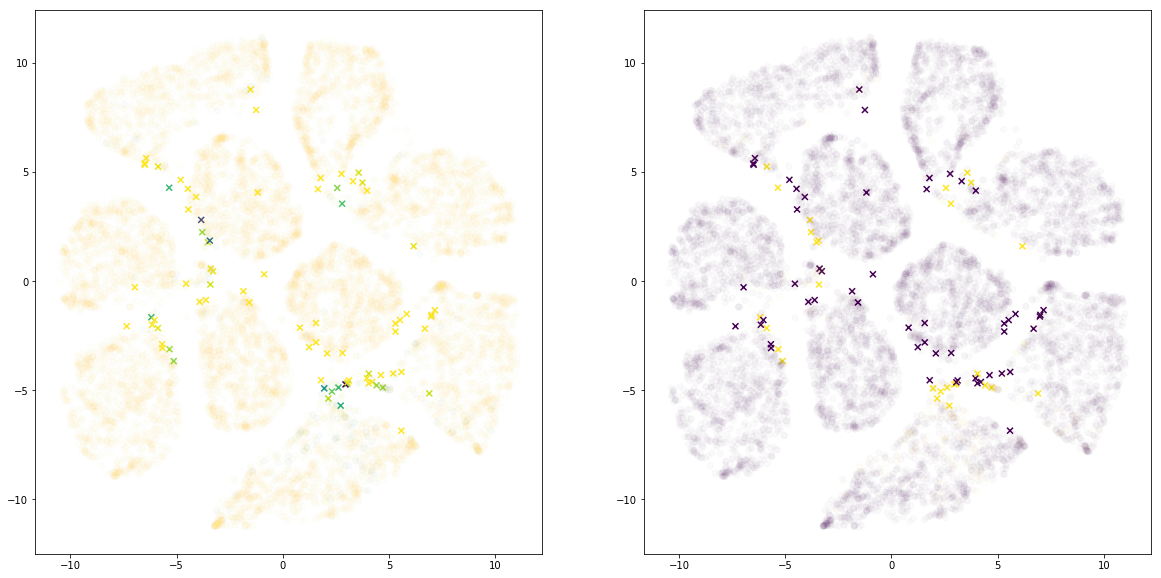

In [30]:
fig, axes = plt.subplots(1,2,figsize=(20,10)) 
# false predictions
axes[0].scatter(tsne_all[:,0][pred_f_te],tsne_all[:,1][pred_f_te],c=probas[pred_f_te], marker='x') # certainty for each point
axes[1].scatter(tsne_all[:,0][pred_f_te],tsne_all[:,1][pred_f_te],c=(probas<np.sort(probas)[300])[pred_f_te], marker='x')  # 300 least certain points in yellow

# true predictions
axes[0].scatter(tsne_all[:,0][pred_t_te],tsne_all[:,1][pred_t_te],c=probas[pred_t_te] ,alpha=.02) # certainty for each point
axes[1].scatter(tsne_all[:,0][pred_t_te],tsne_all[:,1][pred_t_te],c=(probas<np.sort(probas[pred_t_te])[300])[pred_t_te],alpha=.02)  # 300 least certain points in yellow

## Novelty Detection on Activations:
- One-class SVM
- Isolation Forest

### One-class SVM

In [72]:
clf_svm = svm.OneClassSVM(kernel='poly', degree=5, nu=.04, max_iter=100000)

In [73]:
clf_svm.fit(X_train)

OneClassSVM(cache_size=200, coef0=0.0, degree=5, gamma='auto', kernel='poly',
      max_iter=100000, nu=0.04, random_state=None, shrinking=True,
      tol=0.001, verbose=False)

In [74]:
probas = clf_svm.decision_function(X_test)
probas -= np.min(probas)
probas /= np.max(probas)

In [75]:
#predict
probas = clf_svm.predict(X_test)

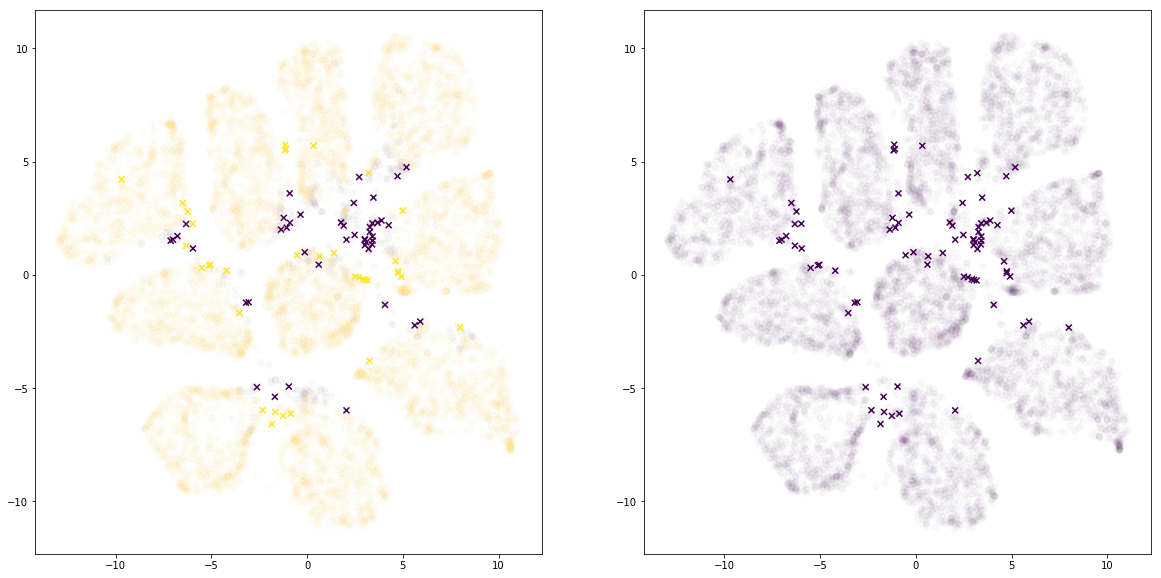

In [76]:
# plot correctly predicted points (x marker)
# plot correctly predicted points (o marker)
fig, axes = plt.subplots(1,2,figsize=(20,10)) 
axes[0].scatter(tsne_all[:,0][pred_t_te],tsne_all[:,1][pred_t_te], c=probas[pred_t_te], alpha=.02) # certainty for each point
axes[1].scatter(tsne_all[:,0][pred_t_te],tsne_all[:,1][pred_t_te], c=(probas<np.sort(probas)[300])[pred_t_te], alpha=.02)  # 300 least certain points in yellow

# plot correctly predicted points (x marker)
# plot correctly predicted points (o marker)
axes[0].scatter(tsne_all[:,0][pred_f_te],tsne_all[:,1][pred_f_te],c=probas[pred_f_te], marker='x') # certainty for each point
axes[1].scatter(tsne_all[:,0][pred_f_te],tsne_all[:,1][pred_f_te],c=(probas<np.sort(probas)[300])[pred_f_te], marker='x')  # 300 least certain points in yellow

In [77]:
# Metrics
# PR
precision_svm, recall_svm, thresholds = metrics.precision_recall_curve(y_true, -probas)
pr_auc_svm = metrics.auc(recall_svm, precision_svm)
# ROC
fpr_svm, tpr_svm, _ = metrics.roc_curve(y_true, -probas)
roc_auc_svm = metrics.roc_auc_score(y_true, -probas)

# Density Forest

In [53]:
root_nodes = df_create(X_train, max_depth=5, min_subset=.1, n_trees=10, subsample_pct=.1, 
          n_max_dim=0, n_jobs=-1, verbose=1, fact_improvement=.01)

Number of points on which to train each tree: 1000
Minimum number of points in each leaf: 100


[Parallel(n_jobs=40)]: Done   8 out of  10 | elapsed:    8.4s remaining:    2.1s


Number of created root nodes: 10
Mean number of clusters created per tree: 14


[Parallel(n_jobs=40)]: Done  10 out of  10 | elapsed:    8.6s finished


In [54]:
probas = df_traverse(X_test, root_nodes, thresh=0)

0.06086705027618957

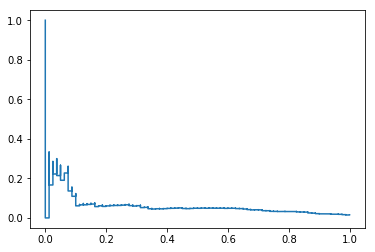

In [55]:
# precision-recall curve
y_scores = -probas
precision_df, recall_df, thresholds = metrics.precision_recall_curve(y_true, y_scores)
pr_auc_df = metrics.auc(recall_df, precision_df)
fpr_df, tpr_df, _ = metrics.roc_curve(y_true, y_scores)
roc_auc_df = metrics.roc_auc_score(y_true, y_scores)
plt.step(recall_df, precision_df)
metrics.auc(recall_df, precision_df)

## Plot Results

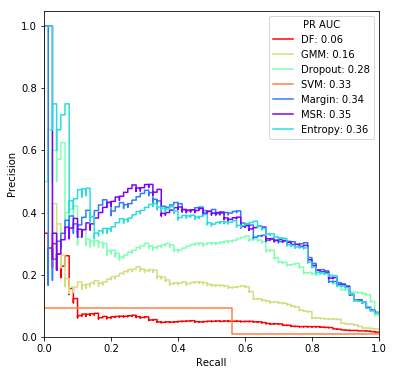

In [78]:
# Precision-Recall Curve
# order according to increasing score
scores_pr = [pr_auc_msr, pr_auc_margin, pr_auc_entropy, pr_auc_dropout, pr_auc_gmm, pr_auc_svm, pr_auc_df]
recalls = [recall_msr, recall_margin, recall_entropy, recall_dropout, recall_gmm, recall_svm, recall_df]
precisions = [precision_msr, precision_margin, precision_entropy, precision_dropout, precision_gmm, precision_svm, precision_df]
names_methods = np.array(['MSR', 'Margin', 'Entropy', 'Dropout', 'GMM', 'SVM', 'DF'])
scores_order = np.argsort(scores_pr)
colors_lines = plt.cm.rainbow(np.linspace(0,1,len(scores_pr)))[:,:3]

# plot
plt.figure(figsize=(6,6))
for i in scores_order:
    plt.step(recalls[i], precisions[i], where='post', c=colors_lines[i])

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.legend([str.format('%s: %.2f') % (names_methods[i], scores_pr[i]) for i in scores_order], title="PR AUC")
plt.savefig("../Figures/MNIST/PR_ED.pdf", bbox_inches='tight', pad_inches=0)
plt.show()

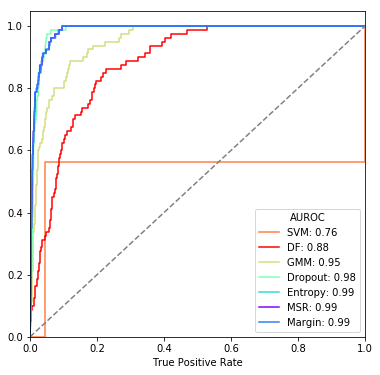

In [79]:
# ROC
# order according to increasing score
scores_auc = [roc_auc_msr, roc_auc_margin, roc_auc_entropy, roc_auc_dropout, roc_auc_gmm, roc_auc_svm, roc_auc_df]
fprs = [fpr_msr, fpr_margin, fpr_entropy, fpr_dropout, fpr_gmm, fpr_svm, fpr_df]
tprs = [tpr_msr, tpr_margin, tpr_entropy, tpr_dropout, tpr_gmm, tpr_svm, tpr_df]
names_methods = np.array(['MSR', 'Margin', 'Entropy', 'Dropout', 'GMM', 'SVM', 'DF'])
scores_order = np.argsort(scores_auc)
colors_lines = plt.cm.rainbow(np.linspace(0,1,len(scores_auc)))[:,:3]

# plot
plt.figure(figsize=(6,6))
for i in scores_order:
    plt.step(fprs[i], tprs[i], where='post', c=colors_lines[i])

plt.plot([0,1],[0,1], '--', c='gray')
plt.xlabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.legend([str.format('%s: %.2f') % (names_methods[i], scores_auc[i]) for i in scores_order], title="AUROC")
plt.savefig("../Figures/MNIST/ROC_ED.pdf", bbox_inches='tight', pad_inches=0)
plt.show()